# zipline MeanReversion Backtest

In the chapter 04, we introduced `Zipline` to simulate the computation of alpha factors from trailing cross-sectional market, fundamental, and alternative data.

Now we will exploit the alpha factors to derive and act on buy and sell signals using the custom MeanReversion factor developed in the last chapter.

## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
import numpy as np
import pandas as pd
from pytz import UTC

from logbook import (NestedSetup, NullHandler, Logger, StreamHandler, StderrHandler, 
                     INFO, WARNING, DEBUG, ERROR)

from zipline import run_algorithm
from zipline.api import (attach_pipeline, 
                         date_rules, 
                         time_rules,
                         get_datetime,
                         order_target_percent,
                         pipeline_output, 
                         record, 
                         schedule_function, 
                         get_open_orders, 
                         calendars,
                         set_commission, 
                         set_slippage)
from zipline.finance import commission, slippage
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.factors import Returns, AverageDollarVolume

from pyfolio.utils import extract_rets_pos_txn_from_zipline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

## Logging Setup

In [3]:
# setup stdout logging
format_string = '[{record.time: %H:%M:%S.%f}]: {record.level_name}: {record.message}'
zipline_logging = NestedSetup([NullHandler(level=DEBUG),
                               StreamHandler(sys.stdout, format_string=format_string, level=INFO),
                               StreamHandler(sys.stderr, level=ERROR)])
zipline_logging.push_application()
log = Logger('Algorithm')

## Algo Settings

In [4]:
# Settings
MONTH = 21
YEAR = 12 * MONTH
N_LONGS = 50
N_SHORTS = 50
VOL_SCREEN = 500

In [5]:
start = pd.Timestamp('2013-01-01')
end = pd.Timestamp('2017-01-01')
capital_base = 1e7

## Mean Reversion Factor

In [6]:
class MeanReversion(CustomFactor):
    """Compute ratio of latest monthly return to 12m average,
       normalized by std dev of monthly returns"""
    inputs = [Returns(window_length=MONTH)]
    window_length = YEAR

    def compute(self, today, assets, out, monthly_returns):
        df = pd.DataFrame(monthly_returns)
        out[:] = df.iloc[-1].sub(df.mean()).div(df.std())

## Create Pipeline

The Pipeline created by the `compute_factors()` method returns a table with a long and a short column for the 25 stocks with the largest negative and positive deviations of their last monthly return from its annual average, normalized by the standard deviation. It also limited the universe to the 500 stocks with the highest average trading volume over the last 30 trading days. 

In [7]:
def compute_factors():
    """Create factor pipeline incl. mean reversion,
        filtered by 30d Dollar Volume; capture factor ranks"""
    mean_reversion = MeanReversion()
    dollar_volume = AverageDollarVolume(window_length=30)
    return Pipeline(columns={'longs'  : mean_reversion.bottom(N_LONGS),
                             'shorts' : mean_reversion.top(N_SHORTS),
                             'ranking': mean_reversion.rank(ascending=False)},
                    screen=dollar_volume.top(VOL_SCREEN))

Before_trading_start() ensures the daily execution of the pipeline and the recording of the results, including the current prices.

In [8]:
def before_trading_start(context, data):
    """Run factor pipeline"""
    context.factor_data = pipeline_output('factor_pipeline')
    record(factor_data=context.factor_data.ranking)
    assets = context.factor_data.index
    record(prices=data.current(assets, 'price'))

## Set up Rebalancing

The new rebalance() method submits trade orders to the exec_trades() method for the assets flagged for long and short positions by the pipeline with equal positive and negative weights. It also divests any current holdings that are no longer included in the factor signals:

In [9]:
def rebalance(context, data):
    """Compute long, short and obsolete holdings; place trade orders"""
    factor_data = context.factor_data
    assets = factor_data.index
    
    longs = assets[factor_data.longs]
    shorts = assets[factor_data.shorts]
    divest = context.portfolio.positions.keys() - longs.union(shorts)
    log.info('{} | Longs: {:2.0f} | Shorts: {:2.0f} | {:,.2f}'.format(get_datetime().date(),
                                                                     len(longs), 
                                                                     len(shorts),
                                                                     context.portfolio.portfolio_value))

    exec_trades(data, assets=divest, target_percent=0)
    exec_trades(data, assets=longs, target_percent=1 / N_LONGS if N_LONGS else 0)
    exec_trades(data, assets=shorts, target_percent=-1 / N_SHORTS if N_SHORTS else 0)

In [10]:
def exec_trades(data, assets, target_percent):
    """Place orders for assets using target portfolio percentage"""
    for asset in assets:
        if data.can_trade(asset) and not get_open_orders(asset):
            order_target_percent(asset, target_percent)

## Initialize Backtest

The `rebalance()` method runs according to `date_rules` and `time_rules` set by the `schedule_function()` utility at the beginning of the week, right after market_open as stipulated by the built-in US_EQUITIES calendar (see docs for details on rules). 

You can also specify a trade commission both in relative terms and as a minimum amount. There is also an option to define slippage, which is the cost of an adverse change in price between trade decision and execution

In [11]:
def initialize(context):
    """Setup: register pipeline, schedule rebalancing,
        and set trading params"""
    attach_pipeline(compute_factors(), 'factor_pipeline')
    schedule_function(rebalance,
                      date_rules.week_start(),
                      time_rules.market_open(),
                      calendar=calendars.US_EQUITIES)

    set_commission(us_equities=commission.PerShare(cost=0.00075, 
                                                   min_trade_cost=.01))
    set_slippage(us_equities=slippage.VolumeShareSlippage(volume_limit=0.0025, 
                                                          price_impact=0.01))

## Run Algorithm

The algorithm executes upon calling the run_algorithm() function and returns the backtest performance DataFrame.

In [12]:
import pandas as pd

# Use the converted start and end dates
backtest = run_algorithm(start=start,
                         end=end,
                         initialize=initialize,
                         before_trading_start=before_trading_start,
                         bundle='quandl',
                         capital_base=capital_base)

[ 12:14:10.212072]: INFO: 2013-01-07 | Longs: 10 | Shorts:  2 | 10,000,000.00
[ 12:14:14.483701]: INFO: 2013-01-14 | Longs: 13 | Shorts:  3 | 10,027,422.36
[ 12:14:15.350018]: INFO: 2013-01-22 | Longs:  8 | Shorts:  5 | 10,097,663.57
[ 12:14:16.050327]: INFO: 2013-01-28 | Longs:  5 | Shorts: 14 | 10,106,150.06
[ 12:14:16.932692]: INFO: 2013-02-04 | Longs: 12 | Shorts: 11 | 10,135,417.26
[ 12:14:17.867463]: INFO: 2013-02-11 | Longs: 11 | Shorts: 13 | 10,182,644.42
[ 12:14:18.802551]: INFO: 2013-02-19 | Longs: 21 | Shorts: 11 | 10,127,755.45
[ 12:14:19.662804]: INFO: 2013-02-25 | Longs: 16 | Shorts:  8 | 10,180,357.23
[ 12:14:20.630616]: INFO: 2013-03-04 | Longs: 10 | Shorts: 10 | 10,200,300.19
[ 12:14:21.540975]: INFO: 2013-03-11 | Longs: 12 | Shorts:  7 | 10,240,453.13
[ 12:14:22.430167]: INFO: 2013-03-18 | Longs:  7 | Shorts:  7 | 10,150,394.01
[ 12:14:23.301034]: INFO: 2013-03-25 | Longs:  8 | Shorts:  7 | 10,149,029.25
[ 12:14:24.013947]: INFO: 2013-04-01 | Longs:  4 | Shorts:  6 | 

## Extract pyfolio Inputs

The `extract_rets_pos_txn_from_zipline` utility provided by `pyfolio` extracts the data used to compute performance metrics.

In [13]:
returns, positions, transactions = extract_rets_pos_txn_from_zipline(backtest)

## Persist Results for use with `pyfolio`

In [14]:
with pd.HDFStore('backtests.h5') as store:
    store.put('backtest/equal_weight', backtest)
    store.put('returns/equal_weight', returns)
    store.put('positions/equal_weight', positions)
    store.put('transactions/equal_weight', transactions)

## Plot Results

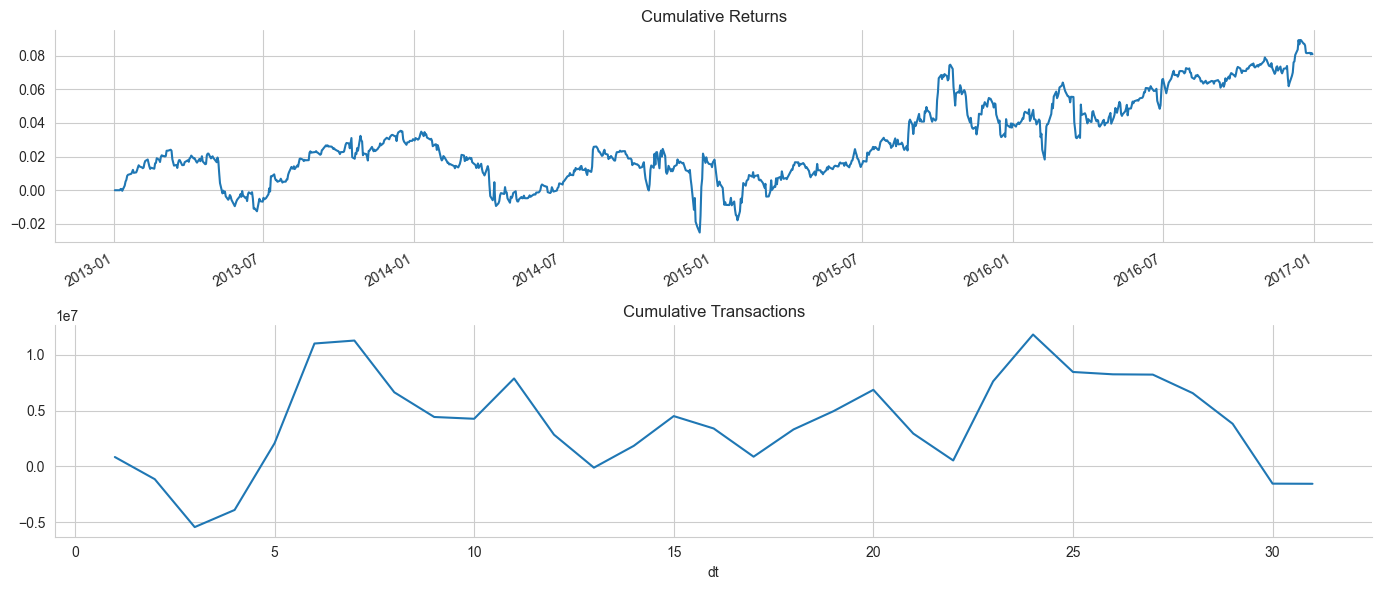

In [15]:
fig, axes= plt.subplots(nrows=2, figsize=(14,6))
returns.add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Returns')
transactions.groupby(transactions.dt.dt.day).txn_dollars.sum().cumsum().plot(ax=axes[1], title='Cumulative Transactions')
fig.tight_layout()
sns.despine();

In [16]:
positions.index = positions.index.date

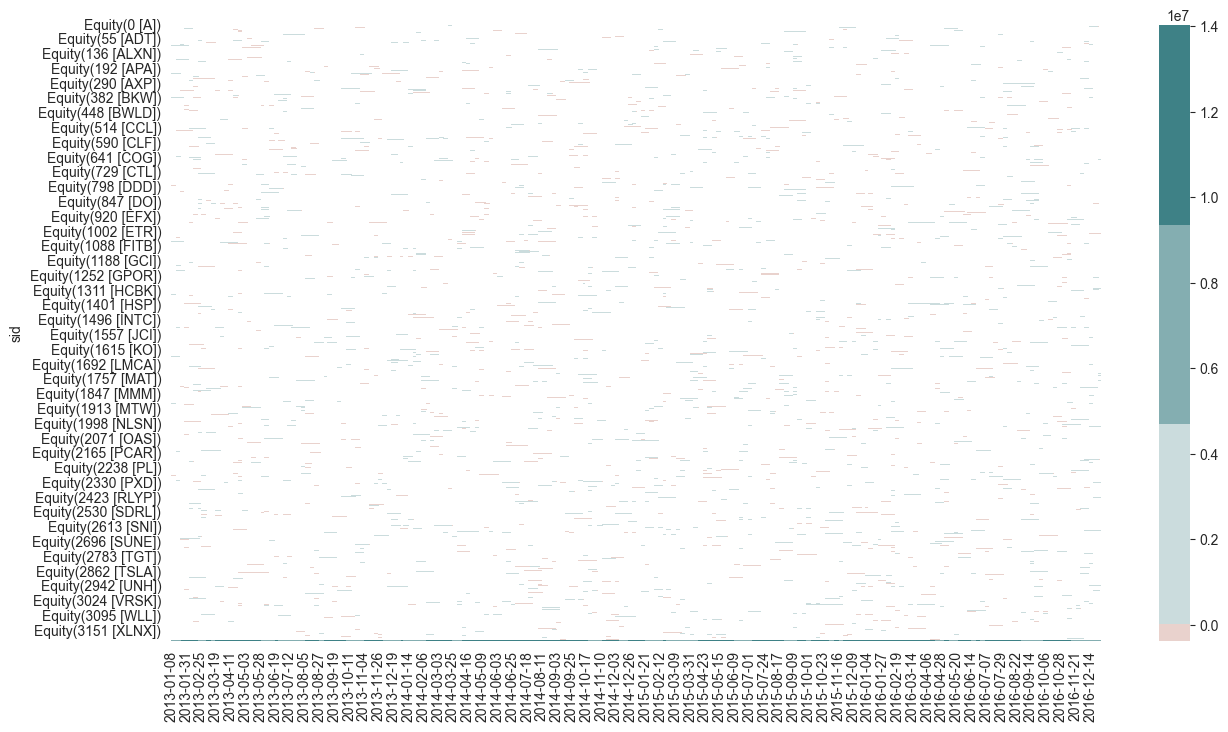

In [17]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(positions.replace(0, np.nan).dropna(how='all', axis=1).T, 
            cmap=sns.diverging_palette(h_neg=20, h_pos=200), ax=ax, center=0);

In [18]:
positions.head()

sid,Equity(0 [A]),Equity(1 [AA]),Equity(2 [AAL]),Equity(7 [AAP]),Equity(8 [AAPL]),Equity(12 [ABBV]),Equity(13 [ABC]),Equity(20 [ABT]),Equity(21 [ACAD]),Equity(27 [ACE]),...,Equity(3156 [XOM]),Equity(3162 [XPO]),Equity(3165 [XRX]),Equity(3171 [YELP]),Equity(3172 [YHOO]),Equity(3175 [YUM]),Equity(3180 [ZBH]),Equity(3194 [ZNGA]),Equity(3197 [ZTS]),cash
2013-01-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.441446e+06
2013-01-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.379079e+06
2013-01-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.379079e+06
2013-01-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.379079e+06
2013-01-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.379079e+06


In [19]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6505 entries, 2013-01-08 21:00:00+00:00 to 2016-12-30 21:00:00+00:00
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   sid          6505 non-null   object             
 1   symbol       6505 non-null   object             
 2   price        6505 non-null   float64            
 3   order_id     6502 non-null   object             
 4   amount       6505 non-null   int64              
 5   commission   0 non-null      object             
 6   dt           6505 non-null   datetime64[ns, UTC]
 7   txn_dollars  6505 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(2), int64(1), object(4)
memory usage: 457.4+ KB


# MeanReversion backtest with Portfolio Optimization

In the chapter 04, we introduced `zipline` to simulate the computation of alpha factors from trailing cross-sectional market, fundamental, and alternative data. 

Now we will exploit the alpha factors to derive and act on buy and sell signals using the custom MeanReversion factor developed in the last chapter.

## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import sys
from pytz import UTC
import logbook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from logbook import (NestedSetup, NullHandler, Logger, 
                     StreamHandler, StderrHandler, 
                     INFO, WARNING, DEBUG, ERROR)

from zipline import run_algorithm
from zipline.api import (attach_pipeline,
                         date_rules,
                         time_rules,
                         get_datetime,
                         order_target_percent,
                         pipeline_output,
                         record, schedule_function,
                         get_open_orders,
                         calendars,
                         set_commission, 
                         set_slippage)
from zipline.finance import commission, slippage
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.factors import Returns, AverageDollarVolume

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, objective_functions
from pypfopt import expected_returns
from pypfopt.exceptions import OptimizationError

from pyfolio.utils import extract_rets_pos_txn_from_zipline

In [7]:
sns.set_style('whitegrid')

## Logging Setup

In [8]:
# setup stdout logging
format_string = '[{record.time: %H:%M:%S.%f}]: {record.level_name}: {record.message}'
zipline_logging = NestedSetup([NullHandler(level=DEBUG),
                               StreamHandler(sys.stdout, format_string=format_string, level=INFO),
                               StreamHandler(sys.stdout, format_string=format_string, level=WARNING),
                               StreamHandler(sys.stderr, level=ERROR)])
zipline_logging.push_application()
log = Logger('Algorithm')

## Algo Settings

In [9]:
# Settings
MONTH = 21
YEAR = 12 * MONTH
N_LONGS = 50
N_SHORTS = 50
MIN_POS = 5
VOL_SCREEN = 1000

In [19]:
start = pd.Timestamp('2013-01-01')
end = pd.Timestamp('2017-01-01')
capital_base = 1e7

## Mean Reversion Factor

In [20]:
class MeanReversion(CustomFactor):
    """Compute ratio of latest monthly return to 12m average,
       normalized by std dev of monthly returns"""
    inputs = [Returns(window_length=MONTH)]
    window_length = YEAR

    def compute(self, today, assets, out, monthly_returns):
        df = pd.DataFrame(monthly_returns)
        factor = df.iloc[-1].sub(df.mean()).div(df.std())
        out[:] = factor

## Create Pipeline

The Pipeline created by the `compute_factors()` method returns a table with a long and a short column for the 25 stocks with the largest negative and positive deviations of their last monthly return from its annual average, normalized by the standard deviation. It also limited the universe to the 500 stocks with the highest average trading volume over the last 30 trading days. 

In [21]:
def compute_factors():
    """Create factor pipeline incl. mean reversion,
        filtered by 30d Dollar Volume; capture factor ranks"""
    mean_reversion = MeanReversion()
    dollar_volume = AverageDollarVolume(window_length=30)
    return Pipeline(columns={'longs'  : mean_reversion.bottom(N_LONGS),
                             'shorts' : mean_reversion.top(N_SHORTS),
                             'ranking': mean_reversion.rank(ascending=False)},
                    screen=dollar_volume.top(VOL_SCREEN))

`Before_trading_start()` ensures the daily execution of the pipeline and the recording of the results, including the current prices.

In [22]:
def before_trading_start(context, data):
    """Run factor pipeline"""
    context.factor_data = pipeline_output('factor_pipeline')
    record(factor_data=context.factor_data.ranking)
    assets = context.factor_data.index
    record(prices=data.current(assets, 'price'))

## Set up Rebalancing

The new `rebalance()` method submits trade orders to the `exec_trades()` method for the assets flagged for long and short positions by the pipeline with equal positive and negative weights. 

It also divests any current holdings that are no longer included in the factor signals:

In [23]:
def exec_trades(data, positions):
    """Place orders for assets using target portfolio percentage"""
    for asset, target_percent in positions.items():
        if data.can_trade(asset) and not get_open_orders(asset):
            order_target_percent(asset, target_percent)

In [24]:
def rebalance(context, data):
    """Compute long, short and obsolete holdings; place orders"""

    factor_data = context.factor_data
    assets = factor_data.index

    longs = assets[factor_data.longs]
    shorts = assets[factor_data.shorts]
    
    divest = context.portfolio.positions.keys() - longs.union(shorts)
    exec_trades(data, positions={asset: 0 for asset in divest})
    log.info('{} | {:11,.0f}'.format(get_datetime().date(), 
                                   context.portfolio.portfolio_value))

    # get price history
    prices = data.history(assets, fields='price',
                          bar_count=252+1, # for 1 year of returns 
                          frequency='1d')
    
    # get optimal weights if sufficient candidates
    if len(longs) > MIN_POS and len(shorts) > MIN_POS:
        try:
            long_weights = optimize_weights(prices.loc[:, longs])
            short_weights = optimize_weights(prices.loc[:, shorts], short=True)
            
            exec_trades(data, positions=long_weights)
            exec_trades(data, positions=short_weights)
        except Exception as e:
            log.warn('{} {}'.format(get_datetime().date(), e))
    # exit remaining positions
    divest_pf = {asset: 0 for asset in context.portfolio.positions.keys()}
    exec_trades(data, positions=divest_pf)

## Optimize Portfolio Weights

In [25]:
def optimize_weights(prices, short=False):

    returns = expected_returns.mean_historical_return(
        prices=prices, frequency=252)
    cov = risk_models.sample_cov(prices=prices, frequency=252)

    # get weights that maximize the Sharpe ratio
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(0, 1),
                           solver='SCS')
    ef.max_sharpe()
    if short:
        return {asset: -weight for asset, weight in ef.clean_weights().items()}
    else:
        return ef.clean_weights()

## Initialize Backtest

The `rebalance()` method runs according to `date_rules` and `time_rules` set by the `schedule_function()` utility at the beginning of the week, right after `market_open` as stipulated by the built-in `US_EQUITIES` calendar (see docs for details on rules). 

You can also specify a trade commission both in relative terms and as a minimum amount. There is also an option to define slippage, which is the cost of an adverse change in price between trade decision and execution

In [26]:
def initialize(context):
    """Setup: register pipeline, schedule rebalancing,
        and set trading params"""
    attach_pipeline(compute_factors(), 'factor_pipeline')
    schedule_function(rebalance,
                      date_rules.week_start(),
                      time_rules.market_open(),
                      calendar=calendars.US_EQUITIES)

    set_commission(us_equities=commission.PerShare(cost=0.00075, min_trade_cost=.01))
    set_slippage(us_equities=slippage.VolumeShareSlippage(volume_limit=0.0025, price_impact=0.01))

## Run Algorithm

The algorithm executes upon calling the `run_algorithm()` function and returns the backtest performance `DataFrame`.

In [27]:
backtest = run_algorithm(start=start,
                         end=end,
                         initialize=initialize,
                         before_trading_start=before_trading_start,
                         bundle='quandl',
                         capital_base=capital_base)

[ 12:37:41.408303]: INFO: 2013-01-07 |  10,000,000
[ 12:37:48.346378]: INFO: 2013-01-14 |   9,922,439
[ 12:37:50.729712]: INFO: 2013-01-22 |   9,913,618
[ 12:37:52.933856]: INFO: 2013-01-28 |   9,968,673
[ 12:37:55.361343]: INFO: 2013-02-04 |  10,079,413
[ 12:37:57.912254]: INFO: 2013-02-11 |  10,103,568
[ 12:38:00.470382]: INFO: 2013-02-19 |   9,771,114
[ 12:38:02.952302]: INFO: 2013-02-25 |  10,061,852
[ 12:38:05.659521]: INFO: 2013-03-04 |  10,162,347
[ 12:38:08.201386]: INFO: 2013-03-11 |   9,563,307
[ 12:38:11.911099]: INFO: 2013-03-18 |   9,311,865
[ 12:38:14.544454]: INFO: 2013-03-25 |   9,064,145
[ 12:38:16.970010]: INFO: 2013-04-01 |   8,643,987
[ 12:38:19.680646]: INFO: 2013-04-08 |   8,722,025
[ 12:38:22.451289]: INFO: 2013-04-15 |   8,552,162
[ 12:38:25.321957]: INFO: 2013-04-22 |   8,186,980
[ 12:38:28.132494]: INFO: 2013-04-29 |   9,080,224
[ 12:38:30.841528]: INFO: 2013-05-06 |   8,277,438
[ 12:38:33.677221]: INFO: 2013-05-13 |   8,018,017
[ 12:38:37.546870]: INFO: 2013-

## Extract pyfolio Inputs

The `extract_rets_pos_txn_from_zipline` utility provided by `pyfolio` extracts the data used to compute performance metrics.

In [15]:
returns, positions, transactions = extract_rets_pos_txn_from_zipline(backtest)

## Persist Results for use with `pyfolio`

In [16]:
with pd.HDFStore('backtests.h5') as store:
    store.put('returns/pf_opt', returns)
    store.put('transactions/pf_opt', transactions)

In [17]:
with pd.HDFStore('backtests.h5') as store:
    returns_pf = store['returns/pf_opt']
    tx_pf = store['transactions/pf_opt']
    returns_ew = store['returns/equal_weight']
    tx_ew = store['transactions/equal_weight']

## Plot Results

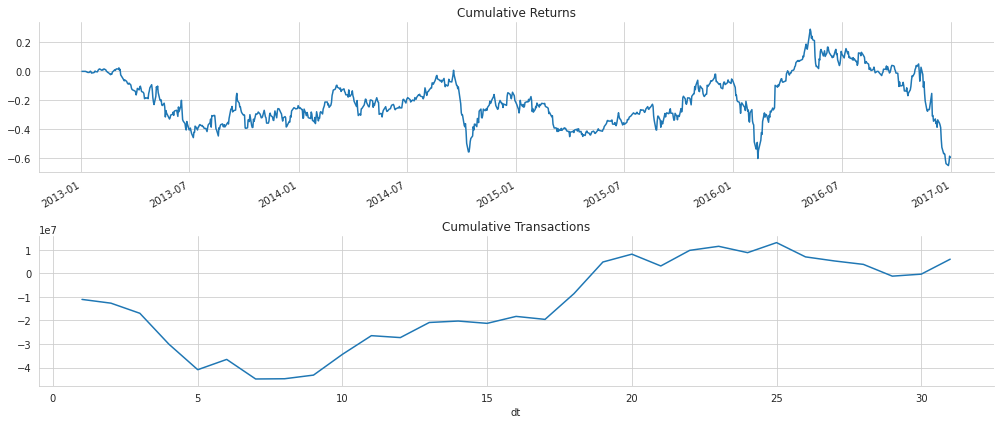

In [18]:
fig, axes= plt.subplots(nrows=2, figsize=(14,6))
returns.add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Returns')
transactions.groupby(transactions.dt.dt.day).txn_dollars.sum().cumsum().plot(ax=axes[1], title='Cumulative Transactions')
sns.despine()
fig.tight_layout();

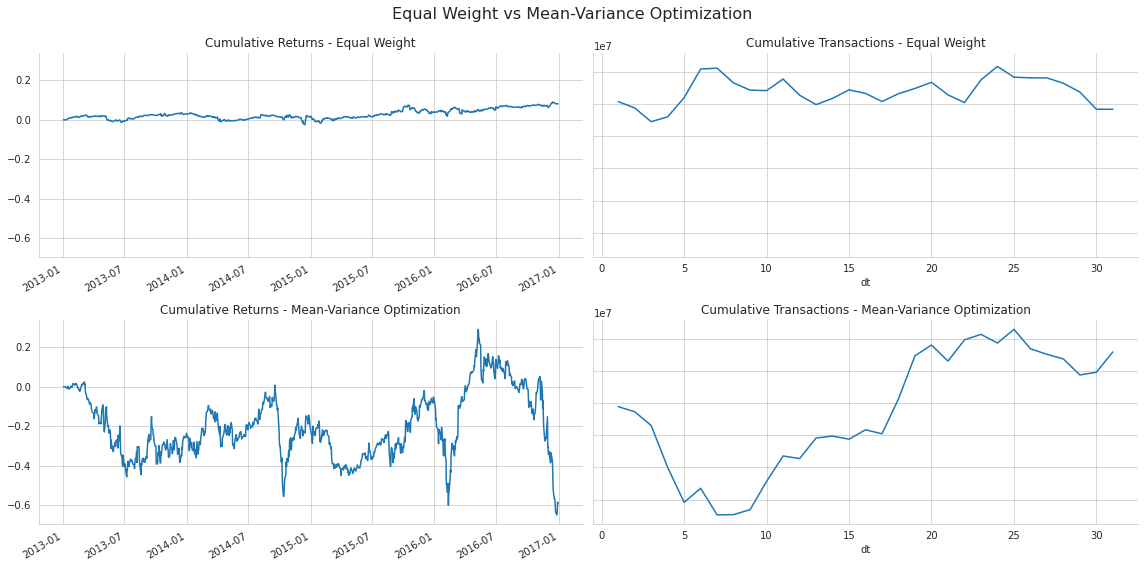

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8), sharey='col')
returns_ew.add(1).cumprod().sub(1).plot(ax=axes[0][0],
                                        title='Cumulative Returns - Equal Weight')
returns_pf.add(1).cumprod().sub(1).plot(ax=axes[1][0],
                                        title='Cumulative Returns - Mean-Variance Optimization')
tx_ew.groupby(tx_ew.dt.dt.day).txn_dollars.sum().cumsum().plot(ax=axes[0][1],
                                                               title='Cumulative Transactions - Equal Weight')
tx_pf.groupby(tx_pf.dt.dt.day).txn_dollars.sum().cumsum().plot(ax=axes[1][1],
                                                               title='Cumulative Transactions - Mean-Variance Optimization')
fig.suptitle('Equal Weight vs Mean-Variance Optimization', fontsize=16)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)

# From `zipline` to `pyfolio`

[Pyfolio](http://quantopian.github.io/pyfolio/) facilitates the analysis of portfolio performance and risk in-sample and out-of-sample using many standard metrics. It produces tear sheets covering the analysis of returns, positions, and transactions, as well as event risk during periods of market stress using several built-in scenarios, and also includes Bayesian out-of-sample performance analysis.

* Open-source backtester by Quantopian Inc.
* Powers Quantopian.com
* State-of-the-art portfolio and risk analytics
* Various models for transaction costs and slippage.
* Open source and free: Apache v2 license
* Can be used:
   - stand alone
   - with Zipline
   - on Quantopian

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyfolio.utils import extract_rets_pos_txn_from_zipline
from pyfolio.plotting import (plot_perf_stats,
                              show_perf_stats,
                              plot_rolling_beta,
                              plot_rolling_returns,
                              plot_rolling_sharpe,
                              plot_drawdown_periods,
                              plot_drawdown_underwater)

from pyfolio.timeseries import perf_stats, extract_interesting_date_ranges

In [3]:
sns.set_style('whitegrid')

## Converting data from zipline to pyfolio

In [4]:
with pd.HDFStore('backtests.h5') as store:
    backtest = store['backtest/equal_weight']
backtest.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1008 entries, 2013-01-02 00:00:00+00:00 to 2016-12-30 00:00:00+00:00
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   period_open              1008 non-null   datetime64[ns, UTC]
 1   period_close             1008 non-null   datetime64[ns, UTC]
 2   ending_value             1008 non-null   float64            
 3   short_value              1008 non-null   float64            
 4   net_leverage             1008 non-null   float64            
 5   shorts_count             1008 non-null   int64              
 6   orders                   1008 non-null   object             
 7   transactions             1008 non-null   object             
 8   returns                  1008 non-null   float64            
 9   ending_cash              1008 non-null   float64            
 10  positions                1008 non-null   object 

`pyfolio` relies on portfolio returns and position data, and can also take into account the transaction costs and slippage losses of trading activity. The metrics are computed using the empyrical library that can also be used on a standalone basis. The performance DataFrame produced by the zipline backtesting engine can be translated into the requisite pyfolio input.

In [5]:
returns, positions, transactions = extract_rets_pos_txn_from_zipline(backtest)

In [6]:
combined = returns.head().combine_first(returns.tail())
combined

2013-01-02 00:00:00+00:00    0.000000
2013-01-03 00:00:00+00:00    0.000000
2013-01-04 00:00:00+00:00    0.000000
2013-01-07 00:00:00+00:00    0.000000
2013-01-08 00:00:00+00:00   -0.000005
2016-12-23 00:00:00+00:00   -0.000233
2016-12-27 00:00:00+00:00    0.000160
2016-12-28 00:00:00+00:00   -0.000847
2016-12-29 00:00:00+00:00    0.000735
2016-12-30 00:00:00+00:00   -0.000606
Name: returns, dtype: float64

In [7]:
positions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1004 entries, 2013-01-08 00:00:00+00:00 to 2016-12-30 00:00:00+00:00
Columns: 750 entries, Equity(0 [A]) to cash
dtypes: float64(750)
memory usage: 5.8 MB


In [8]:
positions.columns = [c for c in positions.columns[:-1]] + ['cash']
positions.index = positions.index.normalize()
positions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1004 entries, 2013-01-08 00:00:00+00:00 to 2016-12-30 00:00:00+00:00
Columns: 750 entries, Equity(0 [A]) to cash
dtypes: float64(750)
memory usage: 5.8 MB


In [9]:
transactions.symbol = transactions.symbol.apply(lambda x: x.symbol)

In [10]:
HDF_PATH = Path('..', 'data', 'assets.h5')

### Sector Map

In [11]:
assets = positions.columns[:-1]
with pd.HDFStore(HDF_PATH) as store:
    df = store.get('us_equities/stocks')['sector'].dropna()
    df = df[~df.index.duplicated()]
sector_map = df.reindex(assets).fillna('Unknown').to_dict()

### Benchmark

In [12]:
with pd.HDFStore(HDF_PATH) as store:
    benchmark_rets = store['sp500/fred'].close.pct_change()
benchmark_rets.name = 'S&P500'
benchmark_rets = benchmark_rets.tz_localize('UTC').filter(returns.index)
benchmark_rets.tail()

2016-12-23 00:00:00+00:00    0.001252
2016-12-27 00:00:00+00:00    0.002248
2016-12-28 00:00:00+00:00   -0.008357
2016-12-29 00:00:00+00:00   -0.000293
2016-12-30 00:00:00+00:00   -0.004637
Name: S&P500, dtype: float64

In [13]:
perf_stats(returns=returns,
           factor_returns=benchmark_rets)
#            positions=positions, 
#            transactions=transactions)

Annual return          0.019619
Cumulative returns     0.080817
Annual volatility      0.047487
Sharpe ratio           0.432879
Calmar ratio           0.336024
Stability              0.555919
Max drawdown          -0.058387
Omega ratio            1.085094
Sortino ratio          0.630497
Skew                   0.223701
Kurtosis               6.125539
Tail ratio             0.988875
Daily value at risk   -0.005901
Alpha                  0.020609
Beta                   0.144371
dtype: float64

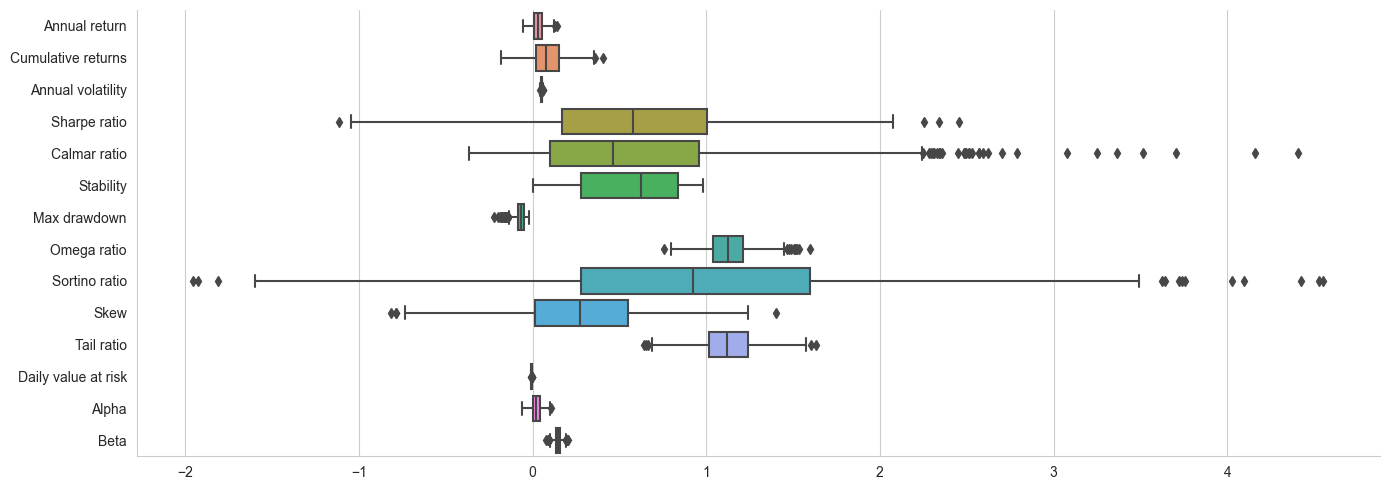

In [14]:
returns, factor_returns = returns.align(benchmark_rets, join='inner')
fig, ax = plt.subplots(figsize=(14, 5))
plot_perf_stats(returns=returns, 
                factor_returns=benchmark_rets,     
                ax=ax)
sns.despine()
fig.tight_layout();

## Returns Analysis

Testing a trading strategy involves backtesting against historical data to fine-tune alpha factor parameters, as well as forward-testing against new market data to validate that the strategy performs well out of sample or if the parameters are too closely tailored to specific historical circumstances.

Pyfolio allows for the designation of an out-of-sample period to simulate walk-forward testing. There are numerous aspects to take into account when testing a strategy to obtain statistically reliable results, which we will address here. 

In [15]:
oos_date = '2016-01-01'

In [16]:
show_perf_stats(returns=returns, 
                factor_returns=benchmark_rets, 
                positions=positions, 
                transactions=transactions, 
                live_start_date=oos_date)

### Rolling Returns OOS

The `plot_rolling_returns` function displays cumulative in and out-of-sample returns against a user-defined benchmark (we are using the S&P 500):


In [17]:
def summarize_paths(samples, cone_std, starting_value):
    cum_mean = samples.mean(axis=1)
    cum_std = samples.std(axis=1)

    if isinstance(cone_std, (float, int)):
        cone_std = [cone_std]

    cone_bounds = pd.DataFrame(columns=pd.Index(cone_std, dtype=float))
    for num_std in cone_std:
        cone_bounds.loc[:, num_std] = cum_mean + cum_std * num_std

    cone_bounds.loc[0] = starting_value
    cone_bounds = cone_bounds.cumprod()

    return cone_bounds

ValueError: Length mismatch: Expected 1000 rows, received array of length 252

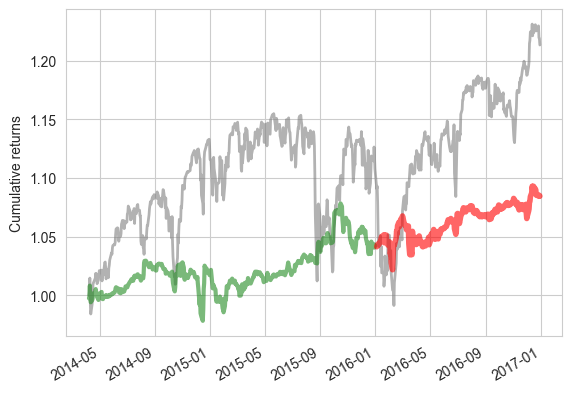

In [18]:
plot_rolling_returns(returns=returns, 
                     factor_returns=benchmark_rets, 
                     live_start_date=oos_date, 
                     cone_std=(1.0, 1.5, 2.0))
plt.gcf().set_size_inches(14, 8)
sns.despine()
plt.tight_layout();

The plot includes a cone that shows expanding confidence intervals to indicate when out-of-sample returns appear unlikely given random-walk assumptions. Here, our strategy did not perform well against the benchmark during the simulated 2017 out-of-sample period

## Summary Performance Statistics

pyfolio offers several analytic functions and plots. The perf_stats summary displays the annual and cumulative returns, volatility, skew, and kurtosis of returns and the SR. The following additional metrics (which can also be calculated individually) are most important:
- Max drawdown: Highest percentage loss from the previous peak
- Calmar ratio: Annual portfolio return relative to maximal drawdown
- Omega ratio: The probability-weighted ratio of gains versus losses for a return target, zero per default
- Sortino ratio: Excess return relative to downside standard deviation
- Tail ratio: Size of the right tail (gains, the absolute value of the 95th percentile) relative to the size of the left tail (losses, abs. value of the 5th percentile) 
- Daily value at risk (VaR): Loss corresponding to a return two standard deviations below the daily mean
- Alpha: Portfolio return unexplained by the benchmark return
- Beta: Exposure to the benchmark


### Rolling Sharpe

In [ ]:
plot_rolling_sharpe(returns=returns)
plt.gcf().set_size_inches(14, 8)
sns.despine()
plt.tight_layout();

### Rolling Beta

In [ ]:
plot_rolling_beta(returns=returns, factor_returns=benchmark_rets)
plt.gcf().set_size_inches(14, 6)
sns.despine()
plt.tight_layout();

## Drawdown Periods

The plot_drawdown_periods(returns) function plots the principal drawdown periods for the portfolio, and several other plotting functions show the rolling SR and rolling factor exposures to the market beta or the Fama French size, growth, and momentum factors:

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
axes = ax.flatten()

plot_drawdown_periods(returns=returns, ax=axes[0])
plot_rolling_beta(returns=returns, factor_returns=benchmark_rets, ax=axes[1])
plot_drawdown_underwater(returns=returns, ax=axes[2])
plot_rolling_sharpe(returns=returns)
sns.despine()
plt.tight_layout();

This plot, which highlights a subset of the visualization contained in the various tear sheets, illustrates how pyfolio allows us to drill down into the performance characteristics and exposure to fundamental drivers of risk and returns.

## Modeling Event Risk

Pyfolio also includes timelines for various events that you can use to compare the performance of a portfolio to a benchmark during this period, for example, during the fall 2015 selloff following the Brexit vote.

In [ ]:
interesting_times = extract_interesting_date_ranges(returns=returns)
(interesting_times['Fall2015']
 .to_frame('momentum_equal_weights').join(benchmark_rets)
 .add(1).cumprod().sub(1)
 .plot(lw=2, figsize=(14, 6), title='Post-Brexit Turmoil'))
sns.despine()
plt.tight_layout();

# Mean-Variance Optimization

MPT solves for the optimal portfolio weights to minimize volatility for a given expected return, or maximize returns for a given level of volatility. The key requisite input are expected asset returns, standard deviations, and the covariance matrix. 

Diversification works because the variance of portfolio returns depends on the covariance of the assets and can be reduced below the weighted average of the asset variances by including assets with less than perfect correlation. In particular, given a vector, ω, of portfolio weights and the covariance matrix, $\Sigma$, the portfolio variance, $\sigma_{\text{PF}}$ is defined as:
$$\sigma_{\text{PF}}=\omega^T\Sigma\omega$$

Markowitz showed that the problem of maximizing the expected portfolio return subject to a target risk has an equivalent dual representation of minimizing portfolio risk subject to a target expected return level, $μ_{PF}$. Hence, the optimization problem becomes:
$$
\begin{align}
\min_\omega & \quad\quad\sigma^2_{\text{PF}}= \omega^T\Sigma\omega\\
\text{s.t.} &\quad\quad \mu_{\text{PF}}= \omega^T\mu\\ 
&\quad\quad \lVert\omega\rVert =1
\end{align}
$$

We can calculate an efficient frontier using `scipy.optimize.minimize` and the historical estimates for asset returns, standard deviations, and the covariance matrix. 

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
from numpy.random import random, uniform, dirichlet, choice
from numpy.linalg import inv

from scipy.optimize import minimize

import pandas_datareader.data as web
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [3]:
sns.set_style('whitegrid')
np.random.seed(42)

In [4]:
cmap = sns.diverging_palette(10, 240, n=9, as_cmap=True)

## Prepare Data

We select historical data for tickers included in the S&P500 (according to Wikipedia) from 1998-2017.

In [5]:
with pd.HDFStore('../data/assets.h5') as store:
    sp500_stocks = store['sp500/stocks']

In [6]:
sp500_stocks.head()

,ticker,name,gics_sector,gics_sub_industry,location,first_added,cik,founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [8]:
prices_df = pd.read_csv('../data/wiki_prices.csv')
prices_df['date'] = pd.to_datetime(prices_df['date'])
prices_df = prices_df.set_index(['ticker', 'date'])
prices = prices_df.adj_close.unstack('ticker')


In [ ]:
# with pd.HDFStore('../data/assets.h5') as store:
#     prices = (store['quandl/wiki/prices']
#               .adj_close
#               .unstack('ticker')
#               .filter(sp500_stocks.index)
#               .sample(n=30, axis=1))

## Compute Inputs

### Compute Returns

In [9]:
start = 2008
end = 2017

Create month-end monthly returns and drop dates that have no observations:

In [10]:
weekly_returns = prices.loc[f'{start}':f'{end}'].resample('W').last().pct_change().dropna(how='all')
weekly_returns = weekly_returns.dropna(axis=1)
weekly_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 521 entries, 2008-01-13 to 2017-12-31
Freq: W-SUN
Columns: 2492 entries, A to ZUMZ
dtypes: float64(2492)
memory usage: 9.9 MB


### Set  Parameters

In [11]:
stocks = weekly_returns.columns

In [12]:
n_obs, n_assets = weekly_returns.shape
n_assets, n_obs

(2492, 521)

In [13]:
NUM_PF = 100000 # no of portfolios to simulate

In [14]:
x0 = uniform(0, 1, n_assets)
x0 /= np.sum(np.abs(x0))

### Annualization Factor

In [15]:
periods_per_year = round(weekly_returns.resample('A').size().mean())
periods_per_year

52

### Compute Mean Returns, Covariance and Precision Matrix

In [16]:
mean_returns = weekly_returns.mean()
cov_matrix = weekly_returns.cov()

The precision matrix is the inverse of the covariance matrix:

In [17]:
precision_matrix = pd.DataFrame(inv(cov_matrix), index=stocks, columns=stocks)

### Risk-Free Rate

Load historical 10-year Treasury rate:

In [18]:
treasury_10yr_monthly = (web.DataReader('DGS10', 'fred', start, end)
                         .resample('M')
                         .last()
                         .div(periods_per_year)
                         .div(100)
                         .squeeze())

In [19]:
rf_rate = treasury_10yr_monthly.mean()

## Simulate Random Portfolios

The simulation generates random weights using the Dirichlet distribution, and computes the mean, standard deviation, and SR for each sample portfolio using the historical return data:

In [20]:
def simulate_portfolios(mean_ret, cov, rf_rate=rf_rate, short=True):
    alpha = np.full(shape=n_assets, fill_value=.05)
    weights = dirichlet(alpha=alpha, size=NUM_PF)
    if short:
        weights *= choice([-1, 1], size=weights.shape)

    returns = weights @ mean_ret.values + 1
    returns = returns ** periods_per_year - 1
    std = (weights @ weekly_returns.T).std(1)
    std *= np.sqrt(periods_per_year)
    sharpe = (returns - rf_rate) / std
    return pd.DataFrame({'Annualized Standard Deviation': std,
                         'Annualized Returns': returns,
                         'Sharpe Ratio': sharpe}), weights

In [21]:
simul_perf, simul_wt = simulate_portfolios(mean_returns, cov_matrix, short=False)

In [22]:
df = pd.DataFrame(simul_wt)
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,2482,2483,2484,2485,2486,2487,2488,2489,2490,2491
count,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,...,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05
mean,3.940841e-04,4.035018e-04,4.070825e-04,4.004539e-04,4.113325e-04,4.023229e-04,3.956579e-04,4.002513e-04,3.965131e-04,4.052396e-04,...,4.008149e-04,4.005567e-04,4.080358e-04,4.113062e-04,4.063100e-04,3.929330e-04,3.983382e-04,4.005662e-04,4.129260e-04,3.904032e-04
std,1.754533e-03,1.798766e-03,1.825578e-03,1.796339e-03,1.800641e-03,1.820442e-03,1.776389e-03,1.773090e-03,1.758973e-03,1.788008e-03,...,1.795720e-03,1.777680e-03,1.838692e-03,1.860392e-03,1.794859e-03,1.751718e-03,1.764155e-03,1.774671e-03,1.854224e-03,1.748257e-03
min,7.108714e-122,1.439071e-108,7.536441e-96,2.023260e-119,7.091449e-113,7.602789e-100,7.452363e-101,8.985953e-103,3.984817e-105,3.111968e-126,...,2.036827e-119,7.378333e-100,8.503443e-103,6.671615e-104,1.610772e-104,1.029294e-106,8.990606e-104,5.446171e-116,3.335612e-101,2.626093e-107
25%,4.667036e-15,4.390854e-15,4.239959e-15,5.320677e-15,4.759622e-15,3.881610e-15,3.728751e-15,4.592134e-15,4.426949e-15,3.970302e-15,...,3.780093e-15,3.953549e-15,4.292405e-15,4.596253e-15,4.547125e-15,3.947311e-15,4.381598e-15,4.188160e-15,4.245602e-15,4.152400e-15
50%,4.570680e-09,4.196619e-09,4.475476e-09,4.843401e-09,5.233902e-09,4.265443e-09,4.543507e-09,4.311927e-09,4.394839e-09,4.384073e-09,...,4.207811e-09,4.293745e-09,4.791147e-09,4.686088e-09,4.784702e-09,4.102044e-09,4.392031e-09,4.513403e-09,4.649032e-09,4.190859e-09
75%,1.499559e-05,1.526851e-05,1.509178e-05,1.522972e-05,1.551662e-05,1.547468e-05,1.451688e-05,1.512250e-05,1.422143e-05,1.451028e-05,...,1.492550e-05,1.537290e-05,1.436027e-05,1.550946e-05,1.539887e-05,1.398457e-05,1.444031e-05,1.566978e-05,1.566304e-05,1.328645e-05
max,6.501707e-02,5.836866e-02,6.015592e-02,5.602695e-02,4.587599e-02,6.359141e-02,7.054385e-02,5.965086e-02,5.465683e-02,4.160472e-02,...,6.129170e-02,6.219114e-02,5.946719e-02,6.042888e-02,5.003227e-02,6.197479e-02,4.221846e-02,5.248489e-02,5.662192e-02,6.607389e-02


### Plot Simulated Portfolios

Max Sharpe: 24.78%, 29.95%


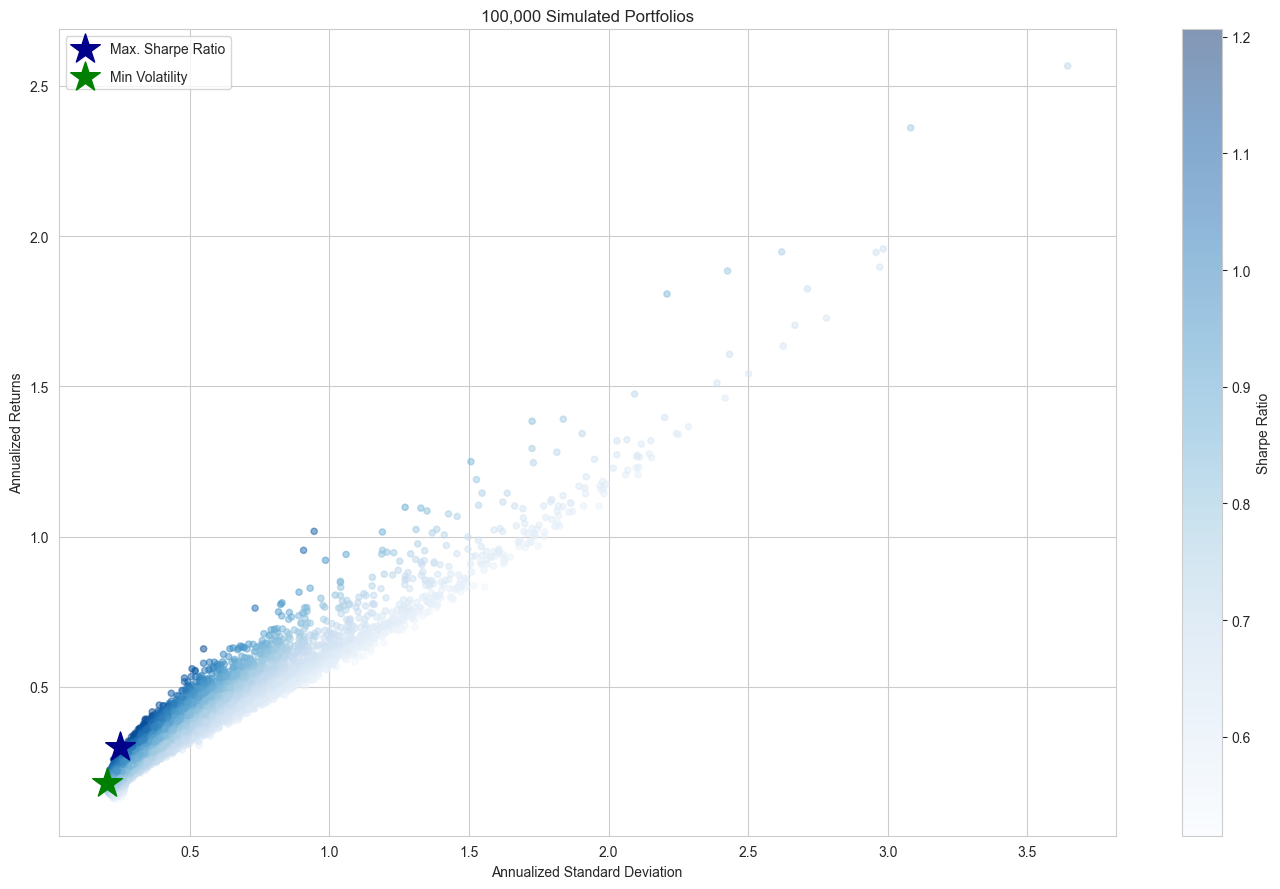

In [23]:
ax = simul_perf.plot.scatter(x=0, y=1, c=2, cmap='Blues',
                             alpha=0.5, figsize=(14, 9), colorbar=True,
                             title=f'{NUM_PF:,d} Simulated Portfolios')

max_sharpe_idx = simul_perf.iloc[:, 2].idxmax()
sd, r = simul_perf.iloc[max_sharpe_idx, :2].values
print(f'Max Sharpe: {sd:.2%}, {r:.2%}')
ax.scatter(sd, r, marker='*', color='darkblue', s=500, label='Max. Sharpe Ratio')

min_vol_idx = simul_perf.iloc[:, 0].idxmin()
sd, r = simul_perf.iloc[min_vol_idx, :2].values
ax.scatter(sd, r, marker='*', color='green', s=500, label='Min Volatility')
plt.legend(labelspacing=1, loc='upper left')
plt.tight_layout()

## Compute Annualize PF Performance

Now we'll set up the quadratic optimization problem to solve for the minimum standard deviation for a given return or the maximum SR. 

To this end, define the functions that measure the key metrics:

In [24]:
def portfolio_std(wt, rt=None, cov=None):
    """Annualized PF standard deviation"""
    return np.sqrt(wt @ cov @ wt * periods_per_year)

In [25]:
def portfolio_returns(wt, rt=None, cov=None):
    """Annualized PF returns"""
    return (wt @ rt + 1) ** periods_per_year - 1

In [26]:
def portfolio_performance(wt, rt, cov):
    """Annualized PF returns & standard deviation"""
    r = portfolio_returns(wt, rt=rt)
    sd = portfolio_std(wt, cov=cov)
    return r, sd

## Max Sharpe PF

Define a target function that represents the negative SR for scipy's minimize function to optimize, given the constraints that the weights are bounded by [-1, 1], if short trading is permitted, and [0, 1] otherwise, and sum to one in absolute terms.

In [27]:
def neg_sharpe_ratio(weights, mean_ret, cov):
    r, sd = portfolio_performance(weights, mean_ret, cov)
    return -(r - rf_rate) / sd

In [28]:
weight_constraint = {'type': 'eq', 
                     'fun': lambda x: np.sum(np.abs(x))-1}

In [29]:
def max_sharpe_ratio(mean_ret, cov, short=False):
    return minimize(fun=neg_sharpe_ratio,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=((-1 if short else 0, 1),) * n_assets,
                    constraints=weight_constraint,
                    options={'tol':1e-10, 'maxiter':1e4})

## Compute Efficient Frontier

The solution requires iterating over ranges of acceptable values to identify optimal risk-return combinations

In [30]:
def min_vol_target(mean_ret, cov, target, short=False):

    def ret_(wt):
        return portfolio_returns(wt, mean_ret)

    constraints = [{'type': 'eq',
                    'fun': lambda x: ret_(x) - target},
                   weight_constraint]

    bounds = ((-1 if short else 0, 1),) * n_assets
    return minimize(portfolio_std,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=bounds,
                    constraints=constraints,
                    options={'tol': 1e-10, 'maxiter': 1e4})

The mean-variance frontier relies on in-sample, backward-looking optimization. In practice, portfolio optimization requires forward-looking input. Unfortunately, expected returns are notoriously difficult to estimate accurately.

The covariance matrix can be estimated somewhat more reliably, which has given rise to several alternative approaches. However, covariance matrices with correlated assets pose computational challenges since the optimization problem requires inverting the matrix. The high condition number induces numerical instability, which in turn gives rise to Markovitz curse: the more diversification is required (by correlated investment opportunities), the more unreliable the weights produced by the algorithm. 

## Min Volatility Portfolio

In [31]:
def min_vol(mean_ret, cov, short=False):
    bounds = ((-1 if short else 0, 1),) * n_assets

    return minimize(fun=portfolio_std,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=bounds,
                    constraints=weight_constraint,
                    options={'tol': 1e-10, 'maxiter': 1e4})

In [32]:
def efficient_frontier(mean_ret, cov, ret_range, short=False):
    return [min_vol_target(mean_ret, cov, ret) for ret in ret_range]

## Run Calculation

### Get random PF

In [33]:
simul_perf, simul_wt = simulate_portfolios(mean_returns, cov_matrix, short=False)

In [33]:
print(simul_perf.describe())

       Annualized Standard Deviation  Annualized Returns   Sharpe Ratio
count                  100000.000000       100000.000000  100000.000000
mean                        0.272889            0.177186       0.675622
std                         0.076975            0.055340       0.213748
min                         0.139966            0.019720       0.055767
25%                         0.217795            0.148334       0.511378
50%                         0.260579            0.173843       0.665910
75%                         0.314480            0.202062       0.834405
max                         0.654543            0.466036       1.332866


In [34]:
simul_max_sharpe = simul_perf.iloc[:, 2].idxmax()
simul_perf.iloc[simul_max_sharpe]

Annualized Standard Deviation    0.166130
Annualized Returns               0.221928
Sharpe Ratio                     1.332866
Name: 67110, dtype: float64

### Get Max Sharpe PF

In [35]:
max_sharpe_pf = max_sharpe_ratio(mean_returns, cov_matrix, short=False)
max_sharpe_perf = portfolio_performance(max_sharpe_pf.x, mean_returns, cov_matrix)

In [36]:
r, sd = max_sharpe_perf
pd.Series({'ret': r, 'sd': sd, 'sr': (r-rf_rate)/sd})

ret    0.228716
sd     0.166360
sr     1.371822
dtype: float64

From simulated pf data

### Get Min Vol PF

In [37]:
min_vol_pf = min_vol(mean_returns, cov_matrix, short=False)
min_vol_perf = portfolio_performance(min_vol_pf.x, mean_returns, cov_matrix)

### Get Efficent PFs

In [38]:
ret_range = np.linspace(simul_perf.iloc[:, 1].min(), simul_perf.iloc[:, 1].max(), 50)
eff_pf = efficient_frontier(mean_returns, cov_matrix, ret_range, short=True)
eff_pf = pd.Series(dict(zip([p['fun'] for p in eff_pf], ret_range)))

### Plot Result

The simulation yields a subset of the feasible portfolios, and the efficient frontier identifies the optimal in-sample return-risk combinations that were achievable given historic data. 

The below figure shows the result including the minimum variance portfolio and the portfolio that maximizes the SR and several portfolios produce by alternative optimization strategies. The efficient frontier 

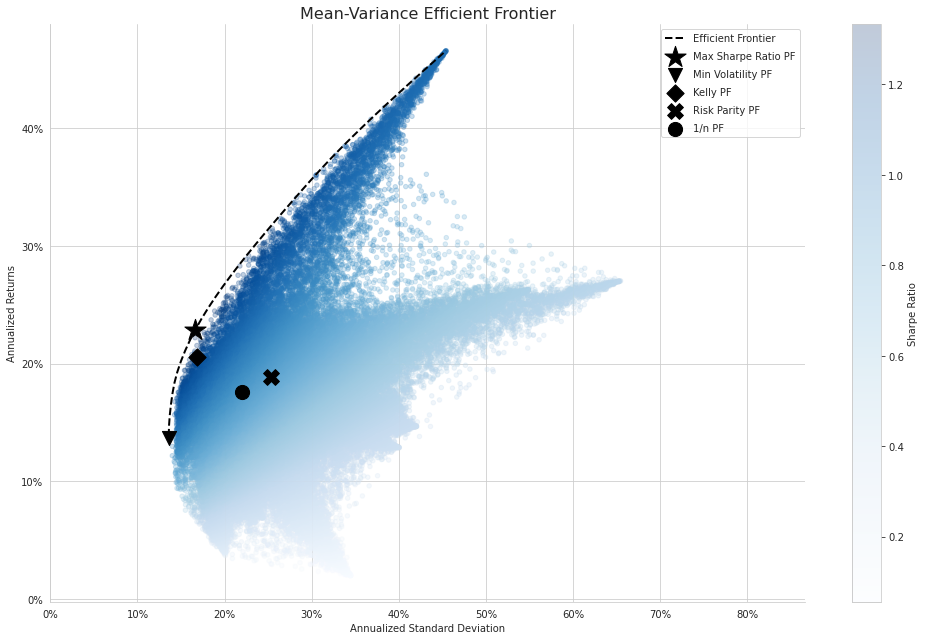

In [39]:
fig, ax = plt.subplots()
simul_perf.plot.scatter(x=0, y=1, c=2, ax=ax, cmap='Blues',alpha=0.25, 
                        figsize=(14, 9), colorbar=True)

eff_pf[eff_pf.index.min():].plot(linestyle='--', lw=2, ax=ax, c='k',
                                 label='Efficient Frontier')

r, sd = max_sharpe_perf
ax.scatter(sd, r, marker='*', color='k', s=500, label='Max Sharpe Ratio PF')

r, sd = min_vol_perf
ax.scatter(sd, r, marker='v', color='k', s=200, label='Min Volatility PF')

kelly_wt = precision_matrix.dot(mean_returns).clip(lower=0).values
kelly_wt /= np.sum(np.abs(kelly_wt))
r, sd = portfolio_performance(kelly_wt, mean_returns, cov_matrix)
ax.scatter(sd, r, marker='D', color='k', s=150, label='Kelly PF')

std = weekly_returns.std()
std /= std.sum()
r, sd = portfolio_performance(std, mean_returns, cov_matrix)
ax.scatter(sd, r, marker='X', color='k', s=250, label='Risk Parity PF')

r, sd = portfolio_performance(np.full(n_assets, 1/n_assets), mean_returns, cov_matrix)
ax.scatter(sd, r, marker='o', color='k', s=200, label='1/n PF')


ax.legend(labelspacing=0.8)
ax.set_xlim(0, eff_pf.max()+.4)
ax.set_title('Mean-Variance Efficient Frontier', fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
sns.despine()
fig.tight_layout();

# How to size your bets - The Kelly Rule

he Kelly rule has a long history in gambling because it provides guidance on how much to stake on each of an (infinite) sequence of bets with varying (but favorable) odds to maximize terminal wealth. It was published as A New Interpretation of the Information Rate in 1956 by John Kelly who was a colleague of Claude Shannon's at Bell Labs. He was intrigued by bets placed on candidates at the new quiz show The $64,000 Question, where a viewer on the west coast used the three-hour delay to obtain insider information about the winners. 

Kelly drew a connection to Shannon's information theory to solve for the bet that is optimal for long-term capital growth when the odds are favorable, but uncertainty remains. His rule maximizes logarithmic wealth as a function of the odds of success of each game, and includes implicit bankruptcy protection since log(0) is negative infinity so that a Kelly gambler would naturally avoid losing everything.

## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
%matplotlib inline
from pathlib import Path

import numpy as np
from numpy.linalg import inv
from numpy.random import dirichlet
import pandas as pd

from sympy import symbols, solve, log, diff
from scipy.optimize import minimize_scalar, newton, minimize
from scipy.integrate import quad
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
sns.set_style('whitegrid')
np.random.seed(42)

In [6]:
DATA_STORE = Path('..', 'data', 'assets.h5')

## The optimal size of a bet

Kelly began by analyzing games with a binary win-lose outcome. The key variables are:
- b: The odds define the amount won for a \\$1 bet. Odds = 5/1 implies a \\$5 gain if the bet wins, plus recovery of the \\$1 capital.
- p: The probability defines the likelihood of a favorable outcome.
- f: The share of the current capital to bet.
- V: The value of the capital as a result of betting.

The Kelly rule aims to maximize the value's growth rate, G, of infinitely-repeated bets (see Chapter 5 for background).
$$G=\lim_{N\rightarrow\infty}=\frac{1}{N}\log\frac{V_N}{V_0}$$

We can maximize the rate of growth G by maximizing G with respect to f, as illustrated using sympy as follows:

In [7]:
share, odds, probability = symbols('share odds probability')
Value = probability * log(1 + odds * share) + (1 - probability) * log(1 - share)
solve(diff(Value, share), share)

[(odds*probability + probability - 1)/odds]

In [8]:
f, p = symbols('f p')
y = p * log(1 + f) + (1 - p) * log(1 - f)
solve(diff(y, f), f)

[2*p - 1]

## Get S&P 500 Data

In [61]:
with pd.HDFStore(DATA_STORE) as store:
    sp500 = store['sp500/stooq'].close

### Compute Returns & Standard Deviation

In [10]:
annual_returns = sp500.resample('A').last().pct_change().dropna().to_frame('sp500')

In [11]:
return_params = annual_returns.sp500.rolling(25).agg(['mean', 'std']).dropna()

In [12]:
return_ci = (return_params[['mean']]
                .assign(lower=return_params['mean'].sub(return_params['std'].mul(2)))
                .assign(upper=return_params['mean'].add(return_params['std'].mul(2))))

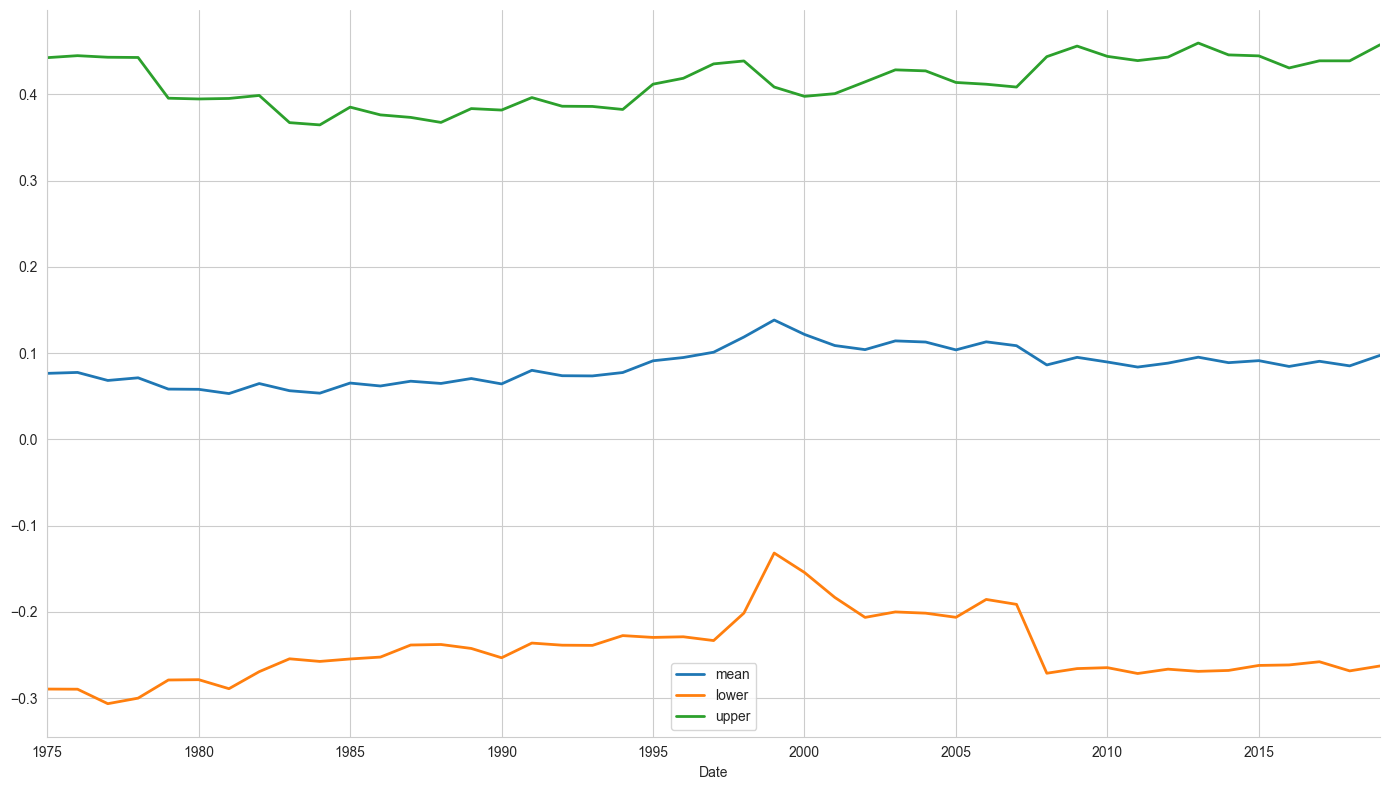

In [13]:
return_ci.plot(lw=2, figsize=(14, 8))
plt.tight_layout()
sns.despine();

### Kelly Rule for a Single Asset - Index Returns

In a financial market context, both outcomes and alternatives are more complex, but the Kelly rule logic does still apply. It was made popular by Ed Thorp, who first applied it profitably to gambling (described in Beat the Dealer) and later started the successful hedge fund Princeton/Newport Partners.

With continuous outcomes, the growth rate of capital is defined by an integrate over the probability distribution of the different returns that can be optimized numerically.
We can solve this expression (see book) for the optimal f* using the `scipy.optimize` module:

In [14]:
def norm_integral(f, mean, std):
    val, er = quad(lambda s: np.log(1 + f * s) * norm.pdf(s, mean, std), 
                               mean - 3 * std, 
                               mean + 3 * std)
    return -val

In [15]:
def norm_dev_integral(f, mean, std):
    val, er = quad(lambda s: (s / (1 + f * s)) * norm.pdf(s, mean, std), m-3*std, mean+3*std)
    return val

In [16]:
def get_kelly_share(data):
    solution = minimize_scalar(norm_integral, 
                        args=(data['mean'], data['std']), 
                        bounds=[0, 2], 
                        method='bounded') 
    return solution.x

In [17]:
annual_returns['f'] = return_params.apply(get_kelly_share, axis=1)

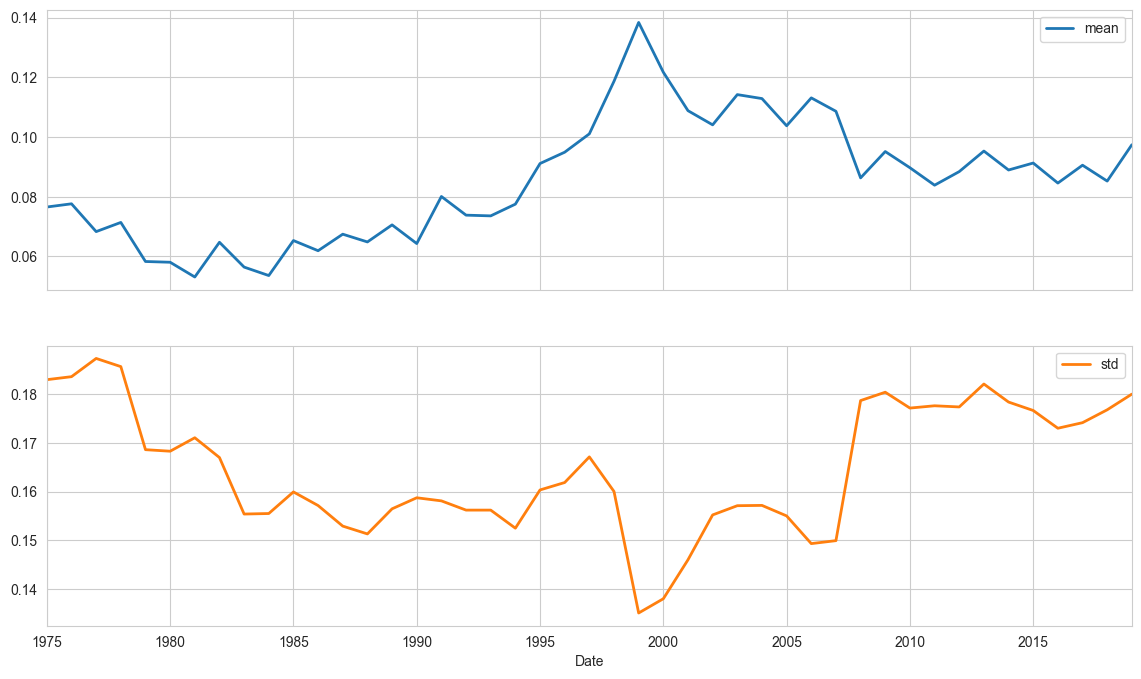

In [18]:
return_params.plot(subplots=True, lw=2, figsize=(14, 8));

In [19]:
annual_returns.tail()

,sp500,f
Date,,
2015-12-31,-0.007266,1.999996
2016-12-31,0.095350,1.999996
2017-12-31,0.194200,1.999996
2018-12-31,-0.062373,1.999996
2019-12-31,0.288781,1.999996


### Performance Evaluation

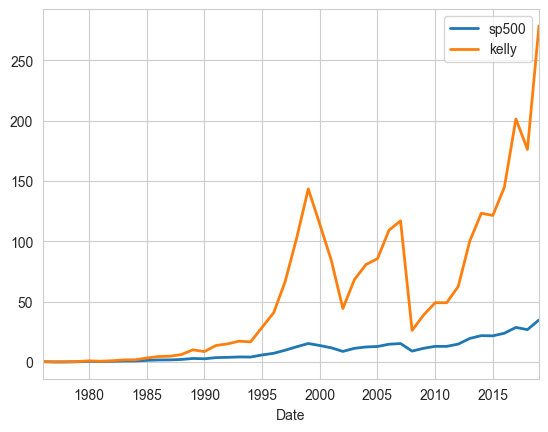

In [20]:
(annual_returns[['sp500']]
 .assign(kelly=annual_returns.sp500.mul(annual_returns.f.shift()))
 .dropna()
 .loc['1900':]
 .add(1)
 .cumprod()
 .sub(1)
 .plot(lw=2));


In [21]:
annual_returns.f.describe()

count    45.000000
mean      1.979025
std       0.062282
min       1.708206
25%       1.999996
50%       1.999996
75%       1.999996
max       1.999996
Name: f, dtype: float64

In [22]:
return_ci.head()

,mean,lower,upper
Date,,,
1975-12-31,0.076574,-0.289442,0.442591
1976-12-31,0.077649,-0.289600,0.444897
1977-12-31,0.068336,-0.306402,0.443074
1978-12-31,0.071410,-0.299973,0.442794
1979-12-31,0.058325,-0.278930,0.395581


### Compute Kelly Fraction

In [23]:
m = .058
s = .216

In [24]:
# Option 1: minimize the expectation integral
sol = minimize_scalar(norm_integral, args=(m, s), bounds=[0., 2.], method='bounded')
print('Optimal Kelly fraction: {:.4f}'.format(sol.x))

Optimal Kelly fraction: 1.1974


In [25]:
# Option 2: take the derivative of the expectation and make it null
x0 = newton(norm_dev_integral, .1, args=(m, s))
print('Optimal Kelly fraction: {:.4f}'.format(x0))

Optimal Kelly fraction: 1.1974


## Kelly Rule for Multiple Assets

We will use an example with various equities. [E. Chan (2008)](https://www.amazon.com/Quantitative-Trading-Build-Algorithmic-Business/dp/0470284889) illustrates how to arrive at a multi-asset application of the Kelly Rule, and that the result is equivalent to the (potentially levered) maximum Sharpe ratio portfolio from the mean-variance optimization. 

The computation involves the dot product of the precision matrix, which is the inverse of the covariance matrix, and the return matrix:

In [53]:
prices_df = pd.read_csv('../data/wiki_prices.csv')
prices_df['date'] = pd.to_datetime(prices_df['date'])
prices_df = prices_df.set_index(['ticker', 'date'])
prices = prices_df.adj_close.unstack('ticker')

In [54]:
prices

ticker,A,AA,AAL,AAMC,AAN,AAOI,AAON,AAP,AAPL,AAT,...,ZIOP,ZIXI,ZLC,ZLTQ,ZMH,ZNGA,ZOES,ZQK,ZTS,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
1962-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-21,69.40,47.95,54.09,60.80,47.37,26.71,39.05,115.24,171.270,32.46,...,4.28,4.53,NaN,NaN,NaN,3.94,15.66,NaN,84.10,23.95
2018-03-22,67.47,44.92,52.31,60.18,45.94,25.96,38.55,111.71,168.845,32.52,...,4.19,4.52,NaN,NaN,NaN,3.81,15.27,NaN,82.06,23.35
2018-03-23,66.06,44.71,51.01,58.35,45.30,25.36,37.20,110.84,164.940,31.78,...,4.05,4.40,NaN,NaN,NaN,3.80,15.12,NaN,80.60,23.55


In [66]:
with pd.HDFStore(DATA_STORE) as store:
    sp500_stocks = store['sp500/stocks'].ticker 
    prices = prices.filter(sp500_stocks)

In [68]:
monthly_returns = prices.loc['1988':'2017'].resample('M').last().pct_change().dropna(how='all').dropna(axis=1)
stocks = monthly_returns.columns
monthly_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 359 entries, 1988-02-29 to 2017-12-31
Freq: ME
Columns: 186 entries, MMM to XEL
dtypes: float64(186)
memory usage: 524.5 KB


### Compute Precision Matrix

In [49]:
cov = monthly_returns.cov()
precision_matrix = pd.DataFrame(inv(cov), index=stocks, columns=stocks)

In [50]:
kelly_allocation = monthly_returns.mean().dot(precision_matrix)

In [51]:
kelly_allocation.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
dtype: float64

In [41]:
kelly_allocation.sum()

0.0

### Largest Portfolio Allocation

The plot shows the tickers that receive an allocation weight > 5x their value:

In [35]:
if not kelly_allocation.empty:
    kelly_allocation[kelly_allocation.abs() > 5].sort_values(ascending=False).plot.barh(figsize=(8, 10))
    plt.yticks(fontsize=12)
    sns.despine()
else:
    print("The kelly_allocation DataFrame is empty.")

The kelly_allocation DataFrame is empty.


IndexError: index 0 is out of bounds for axis 0 with size 0

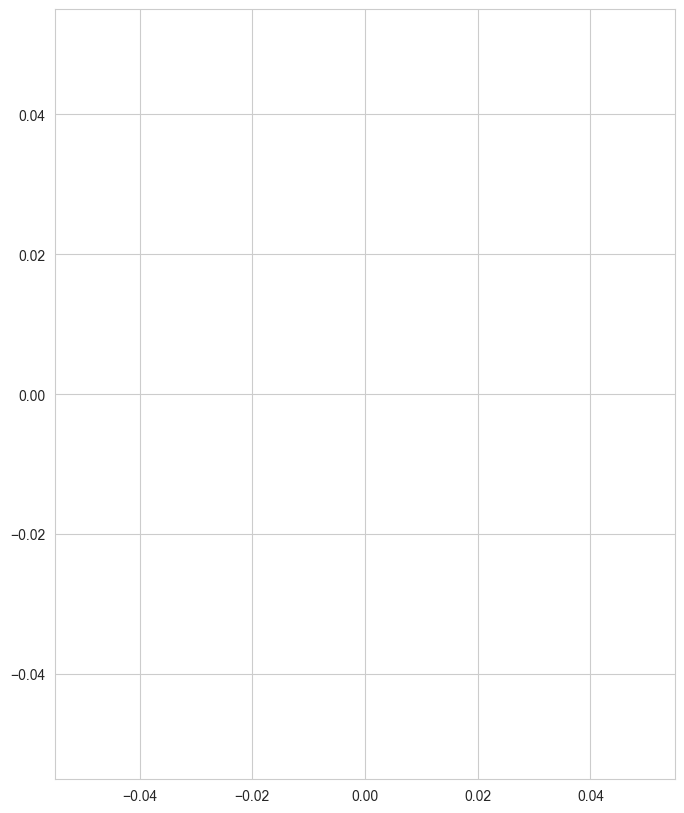

In [36]:
kelly_allocation[kelly_allocation.abs()>5].sort_values(ascending=False).plot.barh(figsize=(8, 10))
plt.yticks(fontsize=12)
sns.despine()
plt.tight_layout();

### Performance vs SP500

The Kelly rule does really well. But it has also been computed from historical data..

ValueError: zero-size array to reduction operation fmin which has no identity

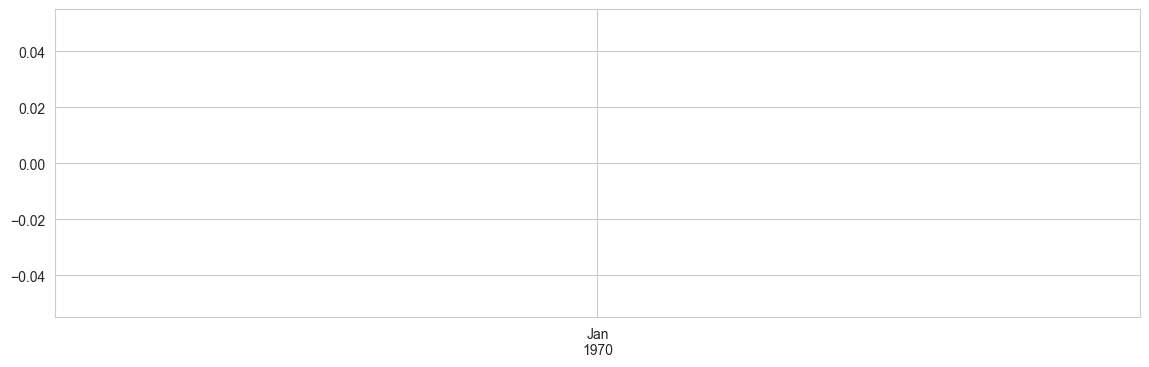

In [34]:
ax = monthly_returns.loc['2010':].mul(kelly_allocation.div(kelly_allocation.sum())).sum(1).to_frame('Kelly').add(1).cumprod().sub(1).plot(figsize=(14,4));
sp500.filter(monthly_returns.loc['2010':].index).pct_change().add(1).cumprod().sub(1).to_frame('SP500').plot(ax=ax, legend=True)
plt.tight_layout()
sns.despine();

# 포트폴리오 최적화와 성과평가
- Alpha factor는 알고리즘 전략을 거래로 변환하여 매수 및 매도 포지션 신호를 생성
    - 생성된 포트폴리오의 수익률과 리스크가 전략의 성공을 결정
- 알고리즘 시뮬레이션 / 전략검증 (파라미터 최적화 포함)


## 포트폴리오 성과를 측정하는 방법
- 다른 전략, 기존 전략과 비교 / 개선하려면 성과를 반영하는 비교 지표가 필요
- 비교지표로는 대체 투자 기회를 나타내는 벤치마크 : S&P 500, 채권에대한 무위험 수익률 등 
- 집라인을 사용하여 시장과 전략의 상호작용을 시뮬레이션 하며, 이후 파이폴리오를 사용한 관련성과를 계산

## 단일 숫자로 리스크수익 트레이드오프 포착
- 수익과 리스크를 트레이트오프 관계이기에 리스크단위단 수익률을 측정하는 계산이 인기
- 샤프비율 : 포트폴리오의 기대수익률을 표준편차로 측정되는 변동성으로 비교하는것. 즉, 리스크를 감수한 단위당 평균초과수익률
$$\mu=E(R_t)=\frac{1}{T}\sum{r_t^e}$$
$$\sigma_{R^e}=Var(R-R^f)=\frac{1}{T}\sum{(r_t^e-\hat\mu_{R^e})^2}$$
$$SR=\frac{\mu-R_f}{\sigma_{R^e}}=\frac{\hat\mu-R_f}{\hat\sigma_{R^e}}$$
- 기대 수익률과 변동성은 관찰할 수 없으나 위와 같이 과저 데이터를 사용하여 추정할 수 있다
- 무위험 이자율이 (신흥시장처럼) 변동성이 크지 않다면 초과 수익률과 수익률의 표준편차는 유사해짐 
    - 독립적으로 동일하게 분포된 수익률에 대해 통계적 유의성 검정을 위한 SR 추정치 분포의 편차는 중심극한정리를 적용하여
    - ~ $N(\mu,\hat\sigma^2)$를 따른다

- 정보비율 : 샤프비율과 비슷하지만 무위험이자율보다 벤치마크(S&P500...등)를 사용
$$IR = \frac{Alpha}{Tracking Error}$$
    > IR은 초과수익률이 매니저의 기술과 전략의 성격에 따라 어떻게 달라지는지 설명하는데 사용

## 적극적 운영의 근본법칙
> "분산투자는 무지에서 자신을 보호하기 위한 것이다. 자신의 투자를 정확히 꿰뚫고 있다면 분산투자는 거의 의미없다" - 워렌버핏
- 높은 정보비율은 추가적 리스크와 비교해 매력인 초과성과를 반영한다
- 적극적 운용의 기본법칙은 **정보계수(IC)** 와 **전략폭(Breadth of strategy)** 의 곱으로 IR을 근사화한다
    - 정보계수(IC) : 수익률 예측과 실제 선도수익률간의 순위상관관계 측정 (잘 플레이 하는지)
    - 전략의 폭 : 투자자가 특정기간동안 베팅(거래)의 독립적 수 (자주 거래하는지)

## 포트폴리오 리스크와 수익률 관리 방법
- 목적 : 벤치마크 관련, 원하는 리스크수익률 트레이드오프를 달성하는 금융상품 포지션을 선택/크기를 조정
- 포트폴리오 매니저는 걱가건머더 분산투자를 최적화하는 포지션을 선택/목표수익률 관리

## 현대 포트폴리오 관리의 진화
- 붅산투자는 불완전한 상관관계 이용, 한 자산의 이익이 다른자산의 손실을 메우기에 리스크 감소시킴.
- 헤리마코위츠(1952)는  현대 포트폴리오이론에서 리스크의 최대수준을 감안 시 수익을 최적화 하는 효율적 프론티어 존재함 주장
    - 포트폴리오 리스크가 모든 자산수익률과 상대적 가중치 사이 공분산에 어떻게 의존하는지 보여줌
- 평균 분산 프론티어는 수익률, 변동성, 상관관계 같은 입력변수의 추정치에 민감, 표본오차를 줄이기 위한 입력변수를 제약하는 평균 분산 포트폴리오가 나은성과
    - 제약 : 동일가중, 최소분산, 리스크패러티 등
- CAPM은 리스크 수익률 관계를 기반으로 하는 자산가치평가모형 
    - 투자자가 리스크 자산을 보유하고자 <U> 시장 균형에서 <U>기대할 수 있는 리스크 프리미엄 개념 도입
    - 분산 불가능 리스크에 대한 경제적 근거에 대한 예> 비즈니스 리스크 거시 팩터가 주식의 기대수익률이나, 채무불이행(부도)에 영향을 줌
    - 자산의 기대 수익률 $E[r_i]$ = 무위험 이자율 $r_i$ + 무위험 이자율을 초과하는 시장포트폴리오 $r_m$  + 기대 초과 수익률에 대한 자산의 노출에 비례하는 리스크프리미엄 $\beta_i$의 수익률
    $$E[r_i] = \alpha_i + r_f + \beta_i(E[r_m]-r_f)$$
        - 이론적으로 시장 포트폴리오는 투자 가능한 모든 자산을 포함하고 균형 상태에서 모든 합리적 투자자가 보유하는 것의미 = S&P500
        - 베타 : 초과수익률에 대한 노출
        - CAPM이 유효하다면 절편항 $\alpha_i$는 0이어야 한다. 
        - 하지만 실제로 CAPM 가정은 충족하지 않는 경우가 많으며 알파는 넓은 시장에 노출되어 설명되지 않은 상태로 남겨진 수익률을 포착
            - 예> 4장에서 본 투자자의 과소/과잉반응 등 행태적 편향 
        - 이러한 팩터는 전문 인덱스 펀드로 거래 될 수 있도록 대안적 베타를 포착하고자 설계된 투자스타일로 진화
- 효율적시장가설(EMH) : 불완전한 정보, 거래, 자금조달, 대리인과 관련된 비용을 포함해 CAPM의 원래 단점을 수정하고자 수십년간 개선 
    - 평균분산최적화와 단점
    - 최소 리스크와 1/n 자산배분과 같은 대안
    - 리스크 패리티 접근법
    - 리스크 팩터 접근법

## 평균분산 최적화
- 입력변수 조정으로 주어진 목표수익률에서 변동성을 최소화하는 최적의 포트폴리오 가중치 구함
    - 필수 입력변수 : 기대자산수익률, 표준편차, 공분산 행렬
- 완전한 상관관계 없는 자산을 포함하며, 자산 분산의 가중평균 이하로 줄임
- $\sigma_{PF}=w^t\sum w$
- $min_w \sigma_{PF}^2=w^T\sum w$ 
- $s.t. w^T=\sigma_{PF}^2$


데이터 준비

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from numpy.random import random, uniform, dirichlet, choice
from numpy.linalg import inv

from scipy.optimize import minimize

import pandas_datareader.data as web
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

sns.set_style('whitegrid')
np.random.seed(42)
cmap = sns.diverging_palette(10, 240, n=9, as_cmap=True)

# Prepare Data
with pd.HDFStore('../data/assets.h5') as store:
    sp500_stocks = store['sp500/stocks']

In [19]:
import pandas as pd

start = pd.Timestamp('2015-01-01')
end = pd.Timestamp('2017-01-01')

prices_df = pd.read_csv('../data/wiki_prices.csv')
prices_df['date'] = pd.to_datetime(prices_df['date'])
prices_df = prices_df.set_index(['ticker', 'date'])

prices = prices_df.adj_close.unstack('ticker')
sampled_prices = prices.sample(n=30, axis=1)
weekly_returns = sampled_prices.loc[start:end].resample('W').last().pct_change().dropna(how='all')

C:\Users\masta\AppData\Local\Temp\ipykernel_1180\519585991.py:12: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  weekly_returns = sampled_prices.loc[start:end].resample('W').last().pct_change().dropna(how='all')


In [20]:
# Set Parameters
stocks = weekly_returns.columns
n_obs, n_assets = weekly_returns.shape
NUM_PF = 100000 # no of portfolios to simulate
x0 = uniform(0, 1, n_assets)
x0 /= np.sum(np.abs(x0))

# Annualization Factor
periods_per_year = round(weekly_returns.resample('A').size().mean())

# Compute Mean Returns, Covariance and Precision Matrix
mean_returns = weekly_returns.mean()
cov_matrix = weekly_returns.cov()
precision_matrix = pd.DataFrame(inv(cov_matrix),
                                index=stocks, columns=stocks)

# Risk-Free Rate (Load historical 10-year Treasury rate)
treasury_10yr_monthly = (web.DataReader('DGS10', 'fred', start, end)
                         .resample('M')
                         .last()
                         .div(periods_per_year)
                         .div(100)
                         .squeeze())
rf_rate = treasury_10yr_monthly.mean()

C:\Users\masta\AppData\Local\Temp\ipykernel_1180\528973838.py:9: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  periods_per_year = round(weekly_returns.resample('A').size().mean())
C:\Users\masta\AppData\Local\Temp\ipykernel_1180\528973838.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  treasury_10yr_monthly = (web.DataReader('DGS10', 'fred', start, end)


디리클레 분포를 사용해 확률가중치를 생성하고 과저 수익률 데이터를 사용하여 각표본의 평균, 표준편차, SR을 계산

In [21]:
def simulate_portfolios(mean_ret, cov, rf_rate=rf_rate, short=True):
    alpha = np.full(shape=n_assets, fill_value=.05)
    weights = dirichlet(alpha=alpha, size=NUM_PF)
    if short:
        weights *= choice([-1, 1], size=weights.shape)

    returns = weights @ mean_ret.values + 1
    returns = returns ** periods_per_year - 1
    std = (weights @ weekly_returns.T).std(1)
    std *= np.sqrt(periods_per_year)
    sharpe = (returns - rf_rate) / std
    return pd.DataFrame({'연간 표준편차': std,
                         '연간 수익': returns,
                         'Sharpe Ratio': sharpe}), weights

주어진 수익률에 대한 최소표준편차나 최대SR을 해결할 2차 최적화문제를 설정. 이를 위해 주요성과 메트릭을 측정하는 함수를 정의

In [22]:
def portfolio_std(wt, rt=None, cov=None):
    """Annualized PF standard deviation"""
    return np.sqrt(wt @ cov @ wt * periods_per_year)
def portfolio_returns(wt, rt=None, cov=None):
    """Annualized PF returns"""
    return (wt @ rt + 1) ** periods_per_year - 1
def portfolio_performance(wt, rt, cov):
    """Annualized PF returns & standard deviation"""
    r = portfolio_returns(wt, rt=rt)
    sd = portfolio_std(wt, cov=cov)
    return r, sd

가중치가 [0,1]로 제한되고 합이 절대적으로 1이 되는 제약조건을 고려해 최적화를 위한 scipy의 최소화 함수에 대한 음(-)의 SR로 나타나는 목표함수를 정의

In [23]:
def neg_sharpe_ratio(weights, mean_ret, cov):
    r, sd = portfolio_performance(weights, mean_ret, cov)
    return -(r - rf_rate) / sd
weight_constraint = {'type': 'eq', 
                     'fun': lambda x: np.sum(np.abs(x))-1}
def max_sharpe_ratio(mean_ret, cov, short=False):
    return minimize(fun=neg_sharpe_ratio,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=((-1 if short else 0, 1),) * n_assets,
                    constraints=weight_constraint,
                    options={'tol':1e-10, 'maxiter':1e4})

- 목표수익률의 범위를 반복하고 대응되는 최소분산 포트폴리오를 해결하여 효율적 프론티어를 계산
    - 포트폴리오의 리스크와 수익률의 제약조건을 가중치 함수로 사용하여 최적화 문제 공식화


In [24]:
def min_vol_target(mean_ret, cov, target, short=False):

    def ret_(wt):
        return portfolio_returns(wt, mean_ret)

    constraints = [{'type': 'eq',
                    'fun': lambda x: ret_(x) - target},
                   weight_constraint]

    bounds = ((-1 if short else 0, 1),) * n_assets
    return minimize(portfolio_std,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=bounds,
                    constraints=constraints,
                    options={'tol': 1e-10, 'maxiter': 1e4})

솔루션은 최적의 리스크 수익 조합을 식별하고자 허용한 값의 범위에서 반복계산이 필요

In [25]:
def efficient_frontier(mean_ret, cov, ret_range, short=False):
    return [min_vol_target(mean_ret, cov, ret) for ret in ret_range]

- 공분산 행렬은 다소 신뢰성 있게 추정될 수 있으며, 대안적 접근법이 생김
- 상관관계 있는 자산을 보유한 공분산 행렬은, 최적화시 역행렬 과정에서 계산의 어려움야기
(마코위츠 저주)
    - 최근은 부담이 적은 투입 요건을 가진 포트폴리오 최적화 기법 선호

### 대안 1/n 포트폴리오

### 대안 최소분산 포트폴리오

### 대안 배팅의 크기를 정하는 방법 : 켈리공식

## 리스크팩터 투자
- 리스크패러티 : 지난 15년간 글로벌 주식시장에서 지속우상향하는 수익률 곡선과 전반적 금리하락으로 리스크 패러티가 선호
- 많은 금융 기관은 포트폴리오를 다양화하고자 리스크 패리티에 대한 전략적 자산배분 세분화
    - 상관관계를 무시(특히 수익률예측을 무시)하고 분산의 역수에 따라 자산을 할당


In [ ]:
var = monthly_returns.var()
risk_parity_weight = var / var.sum()

## 계층적 리스크 패리티

## 트레이딩과 포트폴리오 관리

## 평균 분산 포트폴리오 최적화 구현

## 파이폴리오를 이용한 백테스트 성과 측정

## 수익률과 벤치마크 입력

## 표본 외 수익률로 전진분석

## 요약

In [12]:
# 주피터 노트북 파일의 병합
# 1. 먼저 병합 하려는 노트북 파일과 첨부 프로그램을 다운받아
#    별도의 폴더를 만들어 한 곳에 모읍니다. 
#    파일이름 순으로 병합되므로 파일 이름을 잘 조정해 놓습니다.원본 파일은 변경되지 않습니다.
# 2. 프로그램을 run하면 병합 파일이 생성됩니다. 병합된 결과 파일명은 "merged.ipynb" 입니다.

import json
import os

def get_files():
    # 병합할 노트북 파일의 list 만들기
    notebooks_to_merge = [file.name for file in os.scandir() if file.name.endswith('.ipynb') and file.is_file()]

    # 병합하는 노트북 파일을 정렬한다. 순서대로 병합하는 것으로 간주
    notebooks_to_merge.sort()

    print("다음 노트북이 병합됩니다.")
    for notebook in notebooks_to_merge:
        print(notebook)
    
    return notebooks_to_merge

def merge_notebooks(notebooks, merged_notebook):
    
    '''
    parameters:
    notebooks : 병합할 주피터노트북 파일들 이름
    merged_notebook : 병합된 결과물 파일
    returns : 없음
    '''
    with open (notebooks[0], mode = 'r', encoding = 'utf-8') as f:
        base = json.load(f)
    
    for notebook in notebooks[1:]:
        with open (notebook, mode = 'r', encoding = 'utf-8') as f:
            add = json.load(f)
            base['cells'].extend (add['cells']) 
     
    with open(merged_notebook, mode='w', encoding='utf-8') as f:
        json.dump(base, f)
    
    print(f'병합된 파일: {merged_notebook}')
    
notebooks_to_merge = get_files()
nfile = os.getcwd().split('\\')[-1]
merge_notebooks(notebooks_to_merge, f"{nfile}.ipynb")

다음 노트북이 병합됩니다.
01_backtest_with_trades.ipynb
02_backtest_with_pf_optimization.ipynb
03_pyfolio_demo.ipynb
04_mean_variance_optimization.ipynb
05_kelly_rule.ipynb
Untitled.ipynb
병합된 파일: 05_strategy_evaluation.ipynb
